In [1]:
import sys

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3
cosmo_params = pickle.load(open('data/cosmo_params.pkl', 'rb'))

In [3]:
def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [4]:
param_names = [ 'd1','e0' ,'e1','f0', 'g0','g1']

FIXED = {
         'f1':0.12,
         'd0':2.4,
        }

In [5]:
from os.path import exists
params = {}


ndim = len(param_names)
for box in cosmo_params:
    if('Box5_1400' in box): #something weird going on
        continue
    #check if there is a fit for this box by checking if the corresponding figure exsits
    fig_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, 1.0)
    if(not exists(fig_fname)):
        print('Skipping %s'%(box))
        continue
    sampler = None
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
        sampler = pickle.load(f)
    samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
    final_param_vals = np.percentile(samples,  50,axis=0)
    params[box] = dict(zip(param_names, final_param_vals))

Skipping Box12_1400
Skipping Box15_1400
Skipping Box21_1400
Skipping Box22_1400
Skipping Box35_1400
Skipping Box36_1400
Skipping Box47_1400
Skipping Box49_1400
Skipping Box52_1400
Skipping Box54_1400
Skipping Box63_1400
Skipping Box70_1400
Skipping Box82_1400
Skipping Box85_1400
Skipping Box95_1400


In [6]:
from utils import *
import seaborn as sns
from tqdm import tqdm, trange

In [7]:
import random
box = 'Box_n50_0_1400'
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/emu_pred_for_%s.pkl"%(box), "rb") as f:
        pred_data = pickle.load(f)
a_list = list(pred_data.keys())

In [8]:
import matplotlib as mpl
import matplotlib.colors as mcolors
rainbow = mpl.colormaps['rainbow'].resampled(16)
rainbow_list = [mcolors.rgb2hex(rainbow(i)) for i in range(rainbow.N)]
colors = dict(zip(reversed(a_list), rainbow_list))
cmaps =  dict(zip(a_list, [sns.cubehelix_palette(start=s, light=1, as_cmap=True) for s in np.linspace(0, 3, len(a_list))]))


In [65]:
data = {}
data['training'] = {}
data['testing'] = {}

for a in (a_list):
    data['training'][a] = []
for a in (a_list):
    data['testing'][a] = []

    
for box in tqdm(params):
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/emu_pred_for_%s.pkl"%(box), "rb") as f:
        pred_data = pickle.load(f)
    curr_data = data['training']
    if(pred_data[1.0]['train/test'] == 'test'):
        curr_data = data['testing']
    for a in pred_data:
        Ms, N, edges = pred_data[a]['Ms, N, Edges']
        uncertainty_estimate = pred_data[a]['emulataor_sampled_NvM']
    
        for result_idx in range(len(uncertainty_estimate)):
            result = uncertainty_estimate[result_idx]
            if(pred_data[1.0]['train/test'] == 'train' and result_idx > len(uncertainty_estimate)/10):
                break
            if(pred_data[1.0]['train/test'] == 'test' and result_idx > len(uncertainty_estimate)/1):
                break

            residual = (result-N)/N
            assert(len(Ms) == len(residual))
            for m, res in zip(Ms, residual):
                curr_data[a] += [[m, res]]

100%|██████████| 134/134 [00:20<00:00,  6.68it/s]


In [66]:
import seaborn as sns

In [67]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['text.usetex'] = True

dict_keys([1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459, 0.302679, 0.25])


  0%|          | 0/2 [04:42<?, ?it/s]


Done plotting


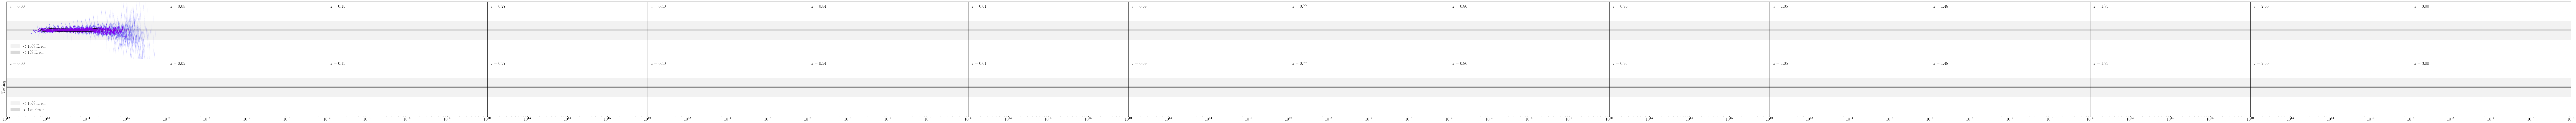

In [69]:
fig, axs_tmp = plt.subplots(nrows=2, ncols=16, figsize=(160,8), sharex=True, sharey=True)
# print(axs_tmp.shape)
# axs_tmp= axs_tmp.T

for ax in axs_tmp.flatten():
    ax.set_ylim((-3e-1, 3e-1))
    ax.set_xlim((1e12, 1e16))

    ax.set_xscale('log')
#     ax.set_yscale('symlog', linthresh=1e-2) 
    ax.set_yticks([])
    ax.axhline(0, c='black')
#     ax.axhline(0.1, c='0.7',)
#     ax.axhline(-0.1, c='0.7',label='10% Error')
#     ax.axhline(0.01, c='0.5', )
#     ax.axhline(-0.01, c='0.5', label='1% Error')
    ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95', label=r'$<10\%$ Error')
    ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85', label=r'$<1\%$ Error')

    ax.axhline(0, c='black')

fig.tight_layout() 


plt.subplots_adjust(wspace=0, hspace=0)

axs = {}
axs['training'] = {}
axs['testing'] = {}
for a, ax in zip(reversed(a_list), axs_tmp[0]):
    axs['training'][a] = ax
    ax.text(.02, 0.95, r'$z=%.2f$'%(scaleToRedshift(a)),
           transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='top',)

for a, ax in zip(reversed(a_list), axs_tmp[1]):
    axs['testing'][a] = ax
    ax.text(.02, 0.95, r'$z=%.2f$'%(scaleToRedshift(a)),
           transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='top',)
    
    
# axs['testing'][0.25].set_xlabel(r'Mass $[h^{-1}M_\odot]$')

print(axs['testing'].keys())
import matplotlib.patches as  mpatches
import matplotlib.lines as  mlines

for key in tqdm(data):
    for a in reversed(data[key]):
        ax = axs[key][a]
        curr_data = np.array(data[key][a])
        X,Y  = curr_data.T
        ax.scatter(X,Y, color=colors[a], alpha=0.005, s=5)
        if(key=='testing'):
            ax.set_xlabel(r'Mass $[h^{-1}M_\odot]$')
        sns.kdeplot(x=X, y=Y, levels=[1-.393], ax=ax, color='k')#,label='kde')

        break
    break
    
print('Done plotting')
        
axs['training'][1.0].legend(frameon=False, loc='lower left')
axs['testing'][1.0].legend(frameon=False, loc='lower left')


axs['training'][1.0].set_ylabel('Training')
axs['testing'][1.0].set_ylabel('Testing')


plt.savefig('meta_emu_perf.png', bbox_inches='tight')
# plt.savefig('meta_emu_perf.pdf', bbox_inches='tight')

<Axes: >

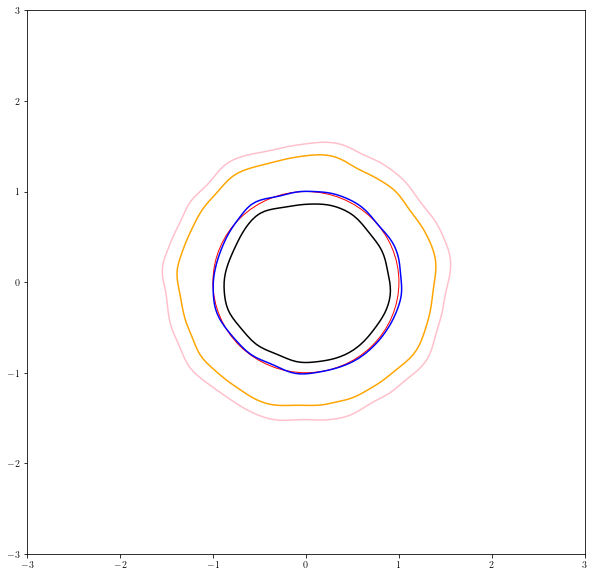

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
X = np.random.normal(size=[100000])
Y = np.random.normal(size=[100000])
# ax.scatter(X,Y, alpha=0.05)
circle1 = plt.Circle((0, 0), 1, color='r', fill=False)
ax.add_patch(circle1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
kde = sns.kdeplot(x=X, y=Y, levels=[.393], ax=ax, color='orange')#,label='kde')
kde = sns.kdeplot(x=X, y=Y, levels=[1-.393], ax=ax, color='blue')#,label='kde') 
#39.3%, see https://corner.readthedocs.io/en/latest/pages/sigmas/, 
 
kde = sns.kdeplot(x=X, y=Y, levels=[.6827], ax=ax, color='k')#,label='kde')
sns.kdeplot(x=X, y=Y, levels=[1-.6827], ax=ax, color='pink')#,label='kde')

#seems like the blue contour is the correct way to get one sigma contour